# Reto Segmentación de datos de empleados

#### Librerías

In [1]:
import os
from zipfile import ZipFile
from dotenv import load_dotenv

import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from kneed import KneeLocator


### Carga de los datos

In [ ]:
load_dotenv('/Users/jvmx/Documents/TLG/.env') #Esta linea carga mis credenciales de acceso a Kaggle, favor de usar las propias o bien el documento. 

!kaggle datasets download -d blurredmachine/hackerearth-employee-attrition
with ZipFile('hackerearth-employee-attrition.zip', 'r') as zip_ref:
    zip_ref.extractall('employee_attrition')

employee_attrition = pd.read_csv('employee_attrition/Test.csv')

display("employee_attrition dataframe",employee_attrition.head())
display(employee_attrition.info())

Dataset URL: https://www.kaggle.com/datasets/blurredmachine/hackerearth-employee-attrition
License(s): other
hackerearth-employee-attrition.zip: Skipping, found more recently modified local copy (use --force to force download)


'employee_attrition dataframe'

,Employee_ID,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,...,Pay_Scale,Compensation_and_Benefits,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7
0,EID_22713,F,32.0,5,Single,Springfield,R&D,Conceptual,7.0,4,...,4.0,type2,1.0,3,-0.9612,-0.4537,2.0,1,8,4
1,EID_9658,M,65.0,2,Single,Lebanon,IT,Directive,41.0,2,...,1.0,type2,1.0,4,-0.9612,0.7075,1.0,2,8,2
2,EID_22203,M,52.0,3,Married,Springfield,Sales,Directive,21.0,3,...,8.0,type3,1.0,4,-0.1048,0.7075,2.0,1,9,3
3,EID_7652,M,50.0,5,Single,Washington,Marketing,Analytical,11.0,4,...,2.0,type0,4.0,3,-0.1048,0.7075,2.0,2,8,3
4,EID_6516,F,44.0,3,Married,Franklin,R&D,Conceptual,12.0,4,...,2.0,type2,4.0,4,1.6081,0.7075,2.0,2,7,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Employee_ID                3000 non-null   object 
 1   Gender                     3000 non-null   object 
 2   Age                        2839 non-null   float64
 3   Education_Level            3000 non-null   int64  
 4   Relationship_Status        3000 non-null   object 
 5   Hometown                   3000 non-null   object 
 6   Unit                       3000 non-null   object 
 7   Decision_skill_possess     3000 non-null   object 
 8   Time_of_service            2948 non-null   float64
 9   Time_since_promotion       3000 non-null   int64  
 10  growth_rate                3000 non-null   int64  
 11  Travel_Rate                3000 non-null   int64  
 12  Post_Level                 3000 non-null   int64  
 13  Pay_Scale                  2997 non-null   float

None

### Pre-procesamiento: Llenar valores nulos

In [22]:
for col in employee_attrition.columns:
    if employee_attrition[col].dtype == 'object':  # Categóricas
        employee_attrition[col] = employee_attrition[col].fillna(employee_attrition[col].mode()[0])
    else:  # Numéricas
        employee_attrition[col] = employee_attrition[col].fillna(employee_attrition[col].median())

employee_attrition.head()

,Employee_ID,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,...,Pay_Scale,Compensation_and_Benefits,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7
0,EID_22713,F,32.0,5,Single,Springfield,R&D,Conceptual,7.0,4,...,4.0,type2,1.0,3,-0.9612,-0.4537,2.0,1,8,4
1,EID_9658,M,65.0,2,Single,Lebanon,IT,Directive,41.0,2,...,1.0,type2,1.0,4,-0.9612,0.7075,1.0,2,8,2
2,EID_22203,M,52.0,3,Married,Springfield,Sales,Directive,21.0,3,...,8.0,type3,1.0,4,-0.1048,0.7075,2.0,1,9,3
3,EID_7652,M,50.0,5,Single,Washington,Marketing,Analytical,11.0,4,...,2.0,type0,4.0,3,-0.1048,0.7075,2.0,2,8,3
4,EID_6516,F,44.0,3,Married,Franklin,R&D,Conceptual,12.0,4,...,2.0,type2,4.0,4,1.6081,0.7075,2.0,2,7,4


### Pre-procesamiento: Transformación de variables de acuerdo a sus características

In [ ]:
# Definir columnas categóricas, ordinales y numéricas
categorical_cols = ['Gender', 'Relationship_Status', 'Hometown', 'Unit', 
                    'Decision_skill_possess', 'Compensation_and_Benefits']
ordinal_cols = ['Education_Level', 'Work_Life_balance', 'Post_Level']
numerical_cols = ['Age', 'Time_of_service', 'Time_since_promotion', 
                  'growth_rate', 'Travel_Rate', 'Pay_Scale', 'VAR1', 'VAR2', 
                  'VAR3', 'VAR4', 'VAR5', 'VAR6', 'VAR7']

# Transformar datos
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols),
        ('ord', OrdinalEncoder(), ordinal_cols),
        ('num', StandardScaler(), numerical_cols)
    ]
)

employee_transformed = preprocessor.fit_transform(employee_attrition)

transformed_columns = (
    preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist() +
    ordinal_cols + numerical_cols
)
df_transformed = pd.DataFrame(employee_transformed, columns=transformed_columns)
df_transformed.head()

,Gender_F,Gender_M,Relationship_Status_Married,Relationship_Status_Single,Hometown_Clinton,Hometown_Franklin,Hometown_Lebanon,Hometown_Springfield,Hometown_Washington,Unit_Accounting and Finance,...,growth_rate,Travel_Rate,Pay_Scale,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-1.051637,0.268727,-0.983392,-0.081620,-1.016359,-0.466229,0.161056,-1.952133,0.754471,0.849984
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.565305,0.268727,-2.415053,1.136585,-1.016359,0.695473,-1.771615,-0.889073,0.754471,-1.364477
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-1.363177,-1.287606,0.925489,1.136585,-0.127422,0.695473,0.161056,-1.952133,1.622012,-0.257247
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-1.176253,0.268727,-1.937833,-0.081620,-0.127422,0.695473,0.161056,-0.889073,0.754471,-0.257247
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.007602,0.268727,-1.937833,1.136585,1.650556,0.695473,0.161056,-0.889073,-0.113069,0.849984


### Selección del número de grupos adecuados para agrupar usando K-means:

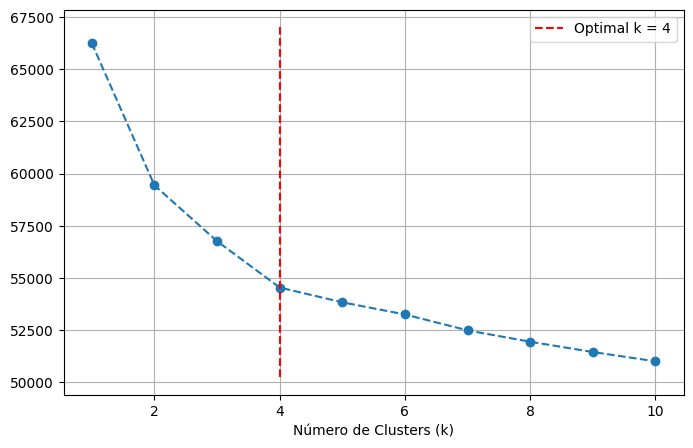

El número óptimo de clusters (k) es: 4


In [27]:
k_values = range(1, 11)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_transformed)
    inertias.append(kmeans.inertia_)

# Encontrar el codo
knee_locator = KneeLocator(k_values, inertias, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o', linestyle='--')
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", colors="red", label=f"Optimal k = {optimal_k}")
plt.xlabel('Número de Clusters (k)')
plt.legend()
plt.grid(True)
plt.show()

print(f"El número óptimo de clusters (k) es: {optimal_k}")

In [29]:
# Ajustar K-means con el número óptimo de clusters
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_transformed['Cluster'] = kmeans.fit_predict(df_transformed)

# Agregar los clusters al DataFrame original
employee_attrition['Cluster'] = df_transformed['Cluster']
employee_attrition.head()

,Employee_ID,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,...,Compensation_and_Benefits,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Cluster
0,EID_22713,F,32.0,5,Single,Springfield,R&D,Conceptual,7.0,4,...,type2,1.0,3,-0.9612,-0.4537,2.0,1,8,4,0
1,EID_9658,M,65.0,2,Single,Lebanon,IT,Directive,41.0,2,...,type2,1.0,4,-0.9612,0.7075,1.0,2,8,2,3
2,EID_22203,M,52.0,3,Married,Springfield,Sales,Directive,21.0,3,...,type3,1.0,4,-0.1048,0.7075,2.0,1,9,3,3
3,EID_7652,M,50.0,5,Single,Washington,Marketing,Analytical,11.0,4,...,type0,4.0,3,-0.1048,0.7075,2.0,2,8,3,2
4,EID_6516,F,44.0,3,Married,Franklin,R&D,Conceptual,12.0,4,...,type2,4.0,4,1.6081,0.7075,2.0,2,7,4,2


### Segmentación del DataFrame original con los empleados separados por grupo:

In [30]:
numeric_columns = employee_attrition.select_dtypes(include='number').columns
cluster_summary = employee_attrition.groupby('Cluster')[numeric_columns].mean()

display("Resumen de los clusters",cluster_summary)

'Resumen de los clusters'

,Age,Education_Level,Time_of_service,Time_since_promotion,growth_rate,Travel_Rate,Post_Level,Pay_Scale,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Cluster
Cluster,,,,,,,,,,,,,,,,,
0,34.931459,3.195079,9.089631,2.302285,46.474517,0.843585,4.478032,6.098418,2.416520,2.996485,-0.046095,-0.010854,1.933216,2.741652,7.179262,3.247803,0.0
1,32.514145,3.230012,7.551046,2.259533,48.000000,0.814268,2.268143,6.231242,1.408364,3.100861,0.002652,0.041918,1.894219,2.857319,7.113161,3.236162,1.0
2,33.239216,3.305882,7.925490,2.308497,46.590850,0.790850,2.309804,5.873203,3.494118,3.040523,0.035141,0.000153,1.934641,2.895425,7.175163,3.269281,2.0
3,55.528722,3.172333,26.565064,2.699883,46.335287,0.861665,2.608441,6.041032,2.283705,3.105510,0.059863,0.010507,1.910903,2.826495,7.073857,3.185229,3.0


#### Visualizar gráficas del resumen

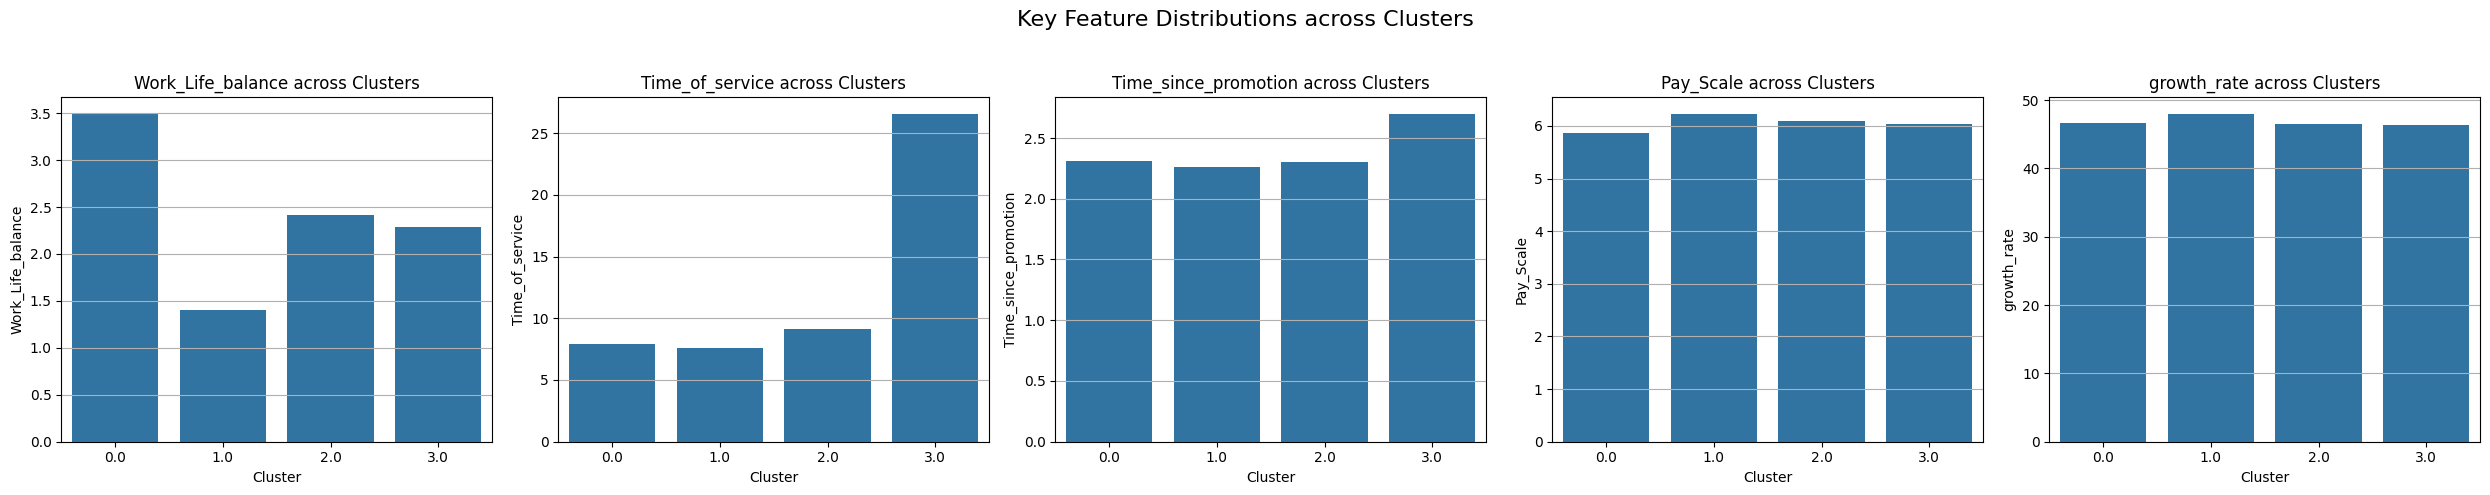

In [ ]:
key_features = ['Work_Life_balance', 'Time_of_service', 'Time_since_promotion', 'Pay_Scale', 'growth_rate']
cluster_summary.index.name = 'Cluster_Index'

fig, axes = plt.subplots(1, 5, figsize=(25, 5))
fig.suptitle('Key Feature Distributions across Clusters', fontsize=16)

for ax, feature in zip(axes, key_features):
    sns.barplot(data=cluster_summary.reset_index(), x='Cluster', y=feature, ax=ax)
    ax.set_title(f'{feature} across Clusters')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)
    ax.grid(axis='y')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

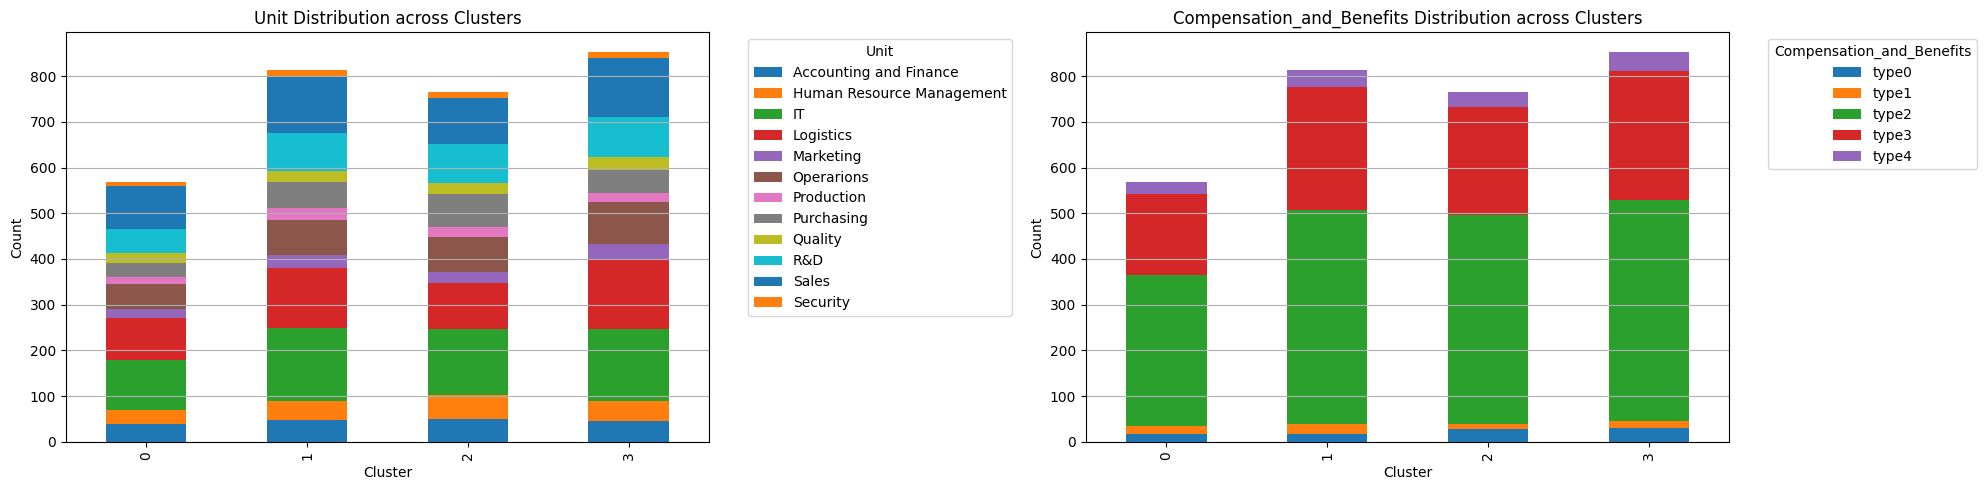

In [31]:
categorical_features = ['Unit', 'Compensation_and_Benefits']

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

for ax, cat_feature in zip(axes, categorical_features):
    category_counts = employee_attrition.groupby(['Cluster', cat_feature]).size().unstack(fill_value=0)
    category_counts.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(f'{cat_feature} Distribution across Clusters')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count')
    ax.legend(title=cat_feature, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(axis='y')

plt.tight_layout()
plt.show()

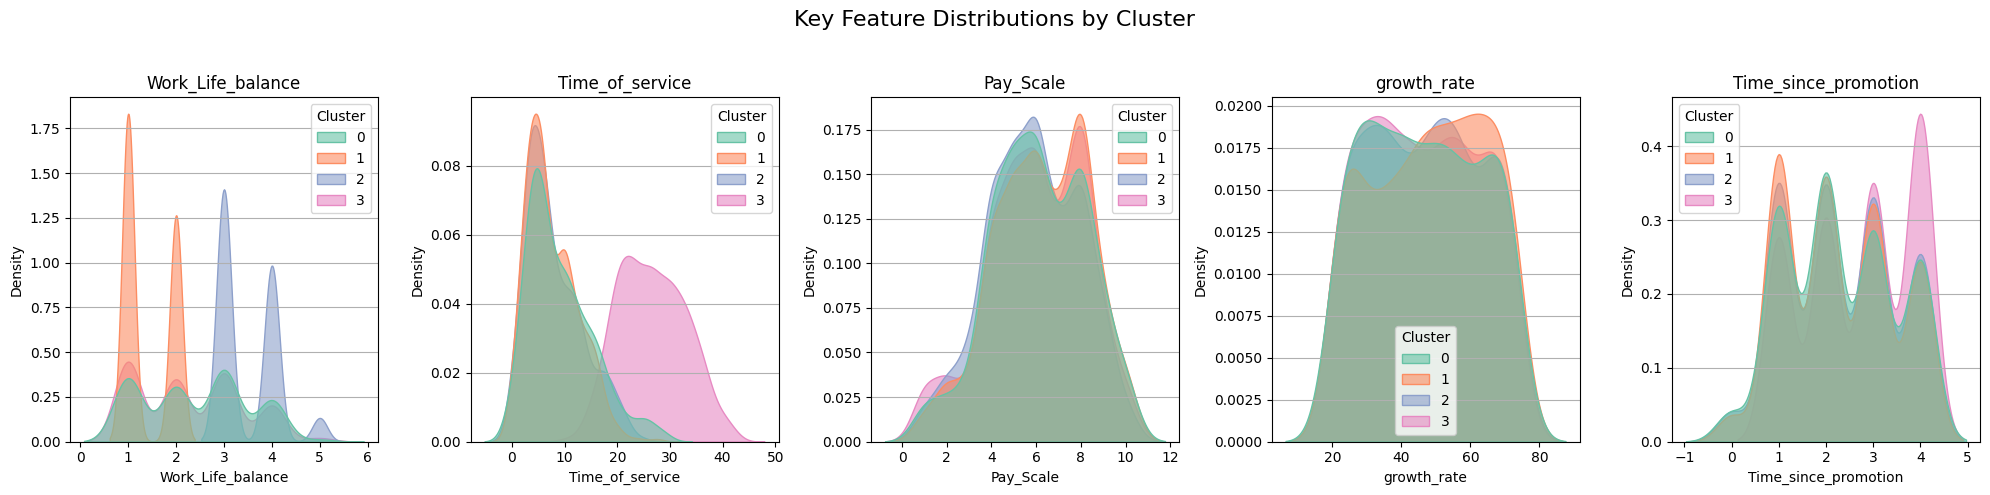

In [32]:
key_features = ['Work_Life_balance', 'Time_of_service', 'Pay_Scale', 'growth_rate', 'Time_since_promotion']

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Key Feature Distributions by Cluster', fontsize=16)

for ax, feature in zip(axes, key_features):
    sns.kdeplot(
        data=employee_attrition, x=feature, hue='Cluster', fill=True, 
        common_norm=False, alpha=0.6, palette='Set2', ax=ax
    )
    ax.set_title(feature)
    ax.set_xlabel(feature)
    ax.grid(axis='y')
    
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [33]:
display(cluster_summary[['Work_Life_balance', 'Time_of_service', 'Pay_Scale']])

,Work_Life_balance,Time_of_service,Pay_Scale
Cluster,,,
0,2.416520,9.089631,6.098418
1,1.408364,7.551046,6.231242
2,3.494118,7.925490,5.873203
3,2.283705,26.565064,6.041032


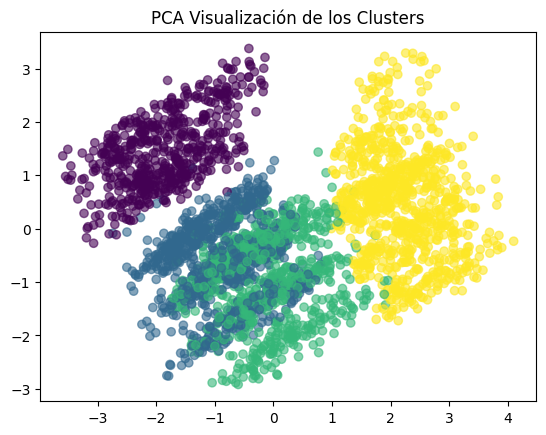

In [35]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_transformed)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df_transformed['Cluster'], cmap='viridis', alpha=0.6)
plt.title('PCA Visualización de los Clusters')
plt.show()

# Conclusiones del Análisis

En este análisis, realizamos un estudio para segmentar a los empleados en grupos mediante técnicas de aprendizaje no supervisado, utilizando el algoritmo **K-Means** y complementándolo con herramientas como el **método del codo**. Nuestro objetivo principal es identificar patrones en los datos que explicaran las dinámicas relacionadas con la deserción y satisfacción de los empleados.

## Segmentación de empleados y Conclusiones clave

El análisis reveló que los empleados pueden agruparse en **4 segmentos principales**. Cada grupo presenta características específicas que permiten comprender mejor las necesidades y motivaciones de los empleados:

1. **Cluster 0: Empleados con bajo tiempo de servicio y balance trabajo-vida crítico**  
   - Estos empleados suelen tener un tiempo corto de servicio en la empresa y presentan un bajo puntaje en **Work_Life_Balance**.
   - **Acciones sugeridas**: Implementar políticas flexibles de horario y mejorar programas de bienestar para reducir el estrés y fomentar la retención.

2. **Cluster 1: Alta experiencia, baja promoción**  
   - Este grupo incluye empleados con un tiempo de servicio alto pero con largos períodos desde su última promoción.
   - **Acciones sugeridas**: Crear planes de desarrollo profesional claros que incluyan promociones y reconocimiento basado en mérito para mantenerlos motivados.

3. **Cluster 2: Empleados jóvenes y en crecimiento**  
   - Este grupo destaca por incluir empleados más jóvenes con altos **growth_rate** y **Pay_Scale** iniciales. Estos empleados parecen estar en fases iniciales de su carrera.
   - **Acciones sugeridas**: Ofrecer oportunidades de aprendizaje continuo y mentorías para impulsar su desarrollo profesional.

4. **Cluster 3: Alta satisfacción general**  
   - Este segmento incluye empleados con un balance trabajo-vida equilibrado, buenas oportunidades de crecimiento y salarios competitivos.
   - **Acciones sugeridas**: Continuar fortaleciendo programas que mantengan esta satisfacción y utilizar este grupo como referencia para diseñar estrategias para otros segmentos.
